### Import libraries

In [2]:
import torch
import numpy as np
import torch.nn as nn
import albumentations as A

from tqdm import tqdm
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2

from models.bisenet.build_bisenet import BiSeNet
from datasets.gta5 import GTA5
from datasets.cityscapes import CityScapes
from utils import fast_hist, per_class_iou

### Import target and source datasets

In [2]:
# Define the custom transform to augment the data
source_transform = A.Compose([
    # Data Normalization is already done in the model!
    # These are the augmentation techniques taken from the best model of step 3b
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
    # Convert the image to tensor
    ToTensorV2()
])

target_transform = A.Compose([
    # In the target domain, we resize the image to 1024x512
    # Then, we normalize the image using the mean and std of the Cityscapes dataset
    A.Resize(width=1024, height=512),
    A.Normalize(
        mean=(0.2954, 0.3339, 0.2950), 
        std=(0.1822, 0.1852, 0.1807),
    ),
    # These are the augmentation techniques taken from the best model of step 3b
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
    # Convert the image to tensor
    ToTensorV2()
])

# Source domain GTA5
source_dataset = GTA5(root_dir='datasets/GTA5', custom_transform=source_transform)
source_loader = DataLoader(source_dataset, batch_size=6, shuffle=True, num_workers=3)

# Target domain Cityscapes
target_dataset = CityScapes(root_dir='datasets/Cityspaces', split='train', custom_transform_image=target_transform)
target_loader = DataLoader(target_dataset, batch_size=3, shuffle=True, num_workers=3)

### Discriminator

In [3]:
# Here we define the discriminator described in the paper
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(num_classes, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.classifier = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = self.leaky_relu(self.conv4(x))
        x = self.classifier(x)
        return self.sigmoid(x)

### Hyperparameter Tuning

In [ ]:
# Define the polynomial learning rate scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=300, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Define the generator loss function
def generator_loss(seg_loss, tgt_pred, discriminator, adv_loss_weight):
    adv_loss = criterion_bce(discriminator(tgt_pred), torch.ones_like(discriminator(tgt_pred)))
    return seg_loss + adv_loss_weight * adv_loss

# Set the device
device = torch.device("cuda")

# Hyperparameters
adv_loss_weights = [0.1, 0.01, 0.03, 0.05, 0.07, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
# Training and evaluation loop
for adv_loss_weight in adv_loss_weights:
    # Load the model
    model = BiSeNet(context_path='resnet18', num_classes=19).to(device)

    # Initialize the discriminator and the optimizer
    discriminator = Discriminator(num_classes=19).to(device)
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
    optimizer_g = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

    # Define the loss function
    criterion_seg = nn.CrossEntropyLoss(ignore_index=255)
    criterion_bce = nn.BCELoss()
    # Training loop
    for epoch in range(50):
        # Initialize the progress bar
        pbar = tqdm(zip(source_loader, target_loader), total=min(len(source_loader), len(target_loader)))
        for i, (source_data, target_data) in enumerate(pbar):
            # Get the source and target data
            src_images, src_labels = source_data
            tgt_images, _ = target_data
            src_images, src_labels = src_images.to(device), src_labels.to(device)
            tgt_images = tgt_images.to(device)

            # Forward pass through the segmentation network
            src_pred = model(src_images)[0]
            tgt_pred = model(tgt_images)[0]

            # Compute segmentation loss on source domain
            seg_loss = criterion_seg(src_pred, src_labels)

            # Train discriminator with source domain predictions (label 1) and target domain predictions (label 0)
            optimizer_d.zero_grad()
            # Detach the source and target predictions to avoid backpropagating through the segmentation network
            src_out_d = discriminator(src_pred.detach())
            tgt_out_d = discriminator(tgt_pred.detach())
            # Compute the discriminator loss
            d_loss_src = criterion_bce(src_out_d, torch.ones_like(src_out_d))
            d_loss_tgt = criterion_bce(tgt_out_d, torch.zeros_like(tgt_out_d))
            d_loss = (d_loss_src + d_loss_tgt) / 2
            d_loss.backward()
            # Update the discriminator
            optimizer_d.step()

            # Train segmentation network with adversarial loss to fool the discriminator
            optimizer_g.zero_grad()
            total_loss = generator_loss(seg_loss, tgt_pred, discriminator, adv_loss_weight)
            total_loss.backward()
            optimizer_g.step()

            # Update learning rate using polynomial decay for the discriminator
            poly_lr_scheduler(optimizer_d, 1e-4, i, max_iter=len(source_loader))

        # Print the loss of each component
        print(f"Epoch [{epoch}/{50}], Seg Loss: {seg_loss.item():.4f}, D Loss: {d_loss.item():.4f}, G Loss: {total_loss.item() - seg_loss.item():.4f}")
    
    print(f"[adv_loss_weight: {adv_loss_weight}] Finished training the model! Saving the model...")
    
    # Save the model
    torch.save(model.state_dict(), f'models/bisenet/bisenet_gta5_adapted/bisenet_gta5_adapted_{adv_loss_weight}.pth')

### Best Parameter

In [4]:
# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

# Set the device
device = torch.device("cuda")
# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)

# Find the best model
adv_loss_weights = [0.1, 0.01, 0.03, 0.05, 0.07, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
mest_miou = 0.0
best_adv_loss_weight = 0.0

# Evaluate the model for each adv_loss_weight
for adv_loss_weight in adv_loss_weights:
    # Load the model for a specific adv_loss_weight
    model.load_state_dict(torch.load(f'models/bisenet/bisenet_gta5_adapted/bisenet_gta5_adapted_{adv_loss_weight}.pth'))
    # Set model to evaluation mode
    model.eval()

    hist = np.zeros((19, 19))
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        # Move the data to the device
        images = images.to(device)
        label = labels.to(device)
        # Forward pass
        output = model(images)[0]
        # Compute the predictions
        pred = output.argmax(dim=0)

        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))
    # Print the mean IoU for each adv_loss_weight
    print(f"[adv_loss_weight: {adv_loss_weight}] Mean IoU: {miou:.4f}")

    # Find the best adv_loss_weight
    if miou > mest_miou:
        mest_miou = miou
        best_adv_loss_weight = adv_loss_weight

# Print the best adv_loss_weight and the best mean IoU
print(f"Best adv_loss_weight: {best_adv_loss_weight}, Best Mean IoU: {mest_miou:.4f}")

100%|██████████| 500/500 [00:08<00:00, 58.89it/s]


[adv_loss_weight: 0.1] Mean IoU: 0.2812


100%|██████████| 500/500 [00:08<00:00, 59.30it/s]


[adv_loss_weight: 0.01] Mean IoU: 0.3017


100%|██████████| 500/500 [00:08<00:00, 57.86it/s]


[adv_loss_weight: 0.03] Mean IoU: 0.2826


100%|██████████| 500/500 [00:08<00:00, 56.52it/s]


[adv_loss_weight: 0.05] Mean IoU: 0.2826


100%|██████████| 500/500 [00:08<00:00, 59.78it/s]


[adv_loss_weight: 0.07] Mean IoU: 0.2721


100%|██████████| 500/500 [00:08<00:00, 60.63it/s]


[adv_loss_weight: 0.3] Mean IoU: 0.2704


100%|██████████| 500/500 [00:08<00:00, 61.59it/s]


[adv_loss_weight: 0.4] Mean IoU: 0.2451


100%|██████████| 500/500 [00:08<00:00, 61.06it/s]


[adv_loss_weight: 0.5] Mean IoU: 0.2515


100%|██████████| 500/500 [00:08<00:00, 62.38it/s]


[adv_loss_weight: 0.6] Mean IoU: 0.2244


100%|██████████| 500/500 [00:08<00:00, 60.78it/s]


[adv_loss_weight: 0.7] Mean IoU: 0.2283


100%|██████████| 500/500 [00:08<00:00, 57.98it/s]

[adv_loss_weight: 0.9] Mean IoU: 0.2091
Best adv_loss_weight: 0.01, Best Mean IoU: 0.3017


### Evaluation

In [5]:
# These are the class labels for the Cityscapes dataset
class_labels = {
    0: 'road',
    1: 'sidewalk',
    2: 'building',
    3: 'wall',
    4: 'fence',
    5: 'pole',
    6: 'traffic light',
    7: 'traffic sign',
    8: 'vegetation',
    9: 'terrain',
    10: 'sky',
    11: 'person',
    12: 'rider',
    13: 'car',
    14: 'truck',
    15: 'bus',
    16: 'train',
    17: 'motorcycle',
    18: 'bicycle'
}

In [10]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load(f'models/bisenet/bisenet_gta5_adapted/bisenet_gta5_adapted_{best_adv_loss_weight}.pth'))
# Set model to evaluation mode
model.eval()

## Get the miou for the Cityscapes dataset in the validation split
# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=6)

# Evaluate the model
hist = np.zeros((19, 19))
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    
# Calculate the mean IoU
miou = np.mean(per_class_iou(hist))
print(f"Mean IoU: {miou:.4f} \n")

class_ious = per_class_iou(hist)
# Print per-class IoU
for i, iou in enumerate(class_ious):
    print(f"{class_labels[i]} IoU: {iou:.4f}")

100%|██████████| 500/500 [00:06<00:00, 81.96it/s]

Mean IoU: 0.3017 

road IoU: 0.8874
sidewalk IoU: 0.3222
building IoU: 0.7610
wall IoU: 0.2103
fence IoU: 0.0944
pole IoU: 0.1641
traffic light IoU: 0.0515
traffic sign IoU: 0.0378
vegetation IoU: 0.7659
terrain IoU: 0.2458
sky IoU: 0.7206
person IoU: 0.3557
rider IoU: 0.0000
car IoU: 0.7520
truck IoU: 0.1874
bus IoU: 0.1099
train IoU: 0.0000
motorcycle IoU: 0.0671
bicycle IoU: 0.0000


### Example

0it [00:00, ?it/s]


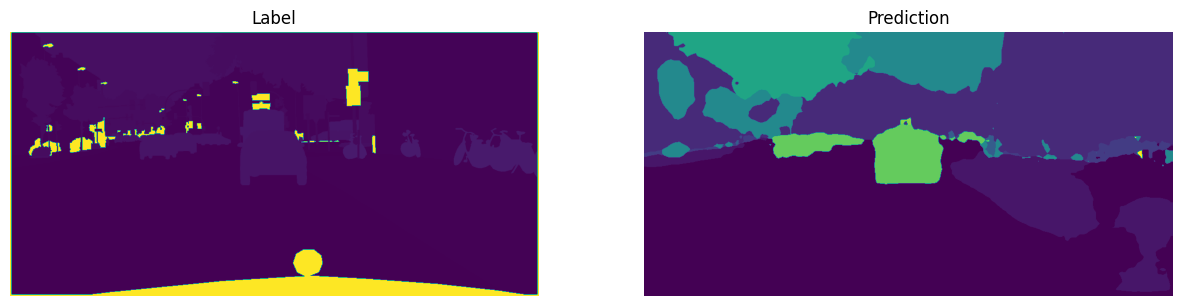

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage

# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet18', num_classes=19).to(device)
model.load_state_dict(torch.load(f"models/bisenet/bisenet_gta5_adapted/bisenet_gta5_adapted_{best_adv_loss_weight}.pth"))
# Set model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

for i, (image, label) in tqdm(enumerate(dataloader)):
    # Move the data to the device
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Stop after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()